# STEP 1: IMPORT LIBRARIES AND DATASETS

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load the datasets
trader_data = pd.read_csv('historical_data.csv')  # Historical Trader Data
sentiment_data = pd.read_csv('fear_greed_index.csv')  # Fear/Greed Data

# Preview the data
print(trader_data.head())
print(sentiment_data.head())


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

# STEP 2: CLEANING COLUMNS

In [9]:
# Rename columns for ease of access
trader_data.columns = trader_data.columns.str.strip().str.replace(' ', '_').str.lower()
sentiment_data.columns = sentiment_data.columns.str.strip().str.replace(' ', '_').str.lower()

# Convert date columns to datetime format
trader_data['timestamp_ist'] = pd.to_datetime(trader_data['timestamp_ist'], format='%d-%m-%Y %H:%M')
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# Extract only the date part from timestamp
trader_data['date'] = trader_data['timestamp_ist'].dt.date
sentiment_data['date'] = sentiment_data['date'].dt.date

# Merge based on date
merged_df = pd.merge(trader_data, sentiment_data[['date', 'classification']], on='date', how='left')

# Check for nulls after merge
print("Missing sentiment labels:", merged_df['classification'].isnull().sum())
print(merged_df[['closed_pnl', 'classification']].head())


Missing sentiment labels: 6
   closed_pnl classification
0         0.0  Extreme Greed
1         0.0  Extreme Greed
2         0.0  Extreme Greed
3         0.0  Extreme Greed
4         0.0  Extreme Greed


# STEP 3: Analyze Trader Performance by Market Sentiment

**Group and Compare Average PnL by Sentiment**

In [12]:
# Basic analysis: mean PnL per sentiment type
avg_pnl = merged_df.groupby('classification')['closed_pnl'].mean().sort_values(ascending=False)
print(avg_pnl)


classification
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Extreme Fear     34.537862
Neutral          34.307718
Name: closed_pnl, dtype: float64


**Visualize PnL vs Sentiment (Box Plot)**

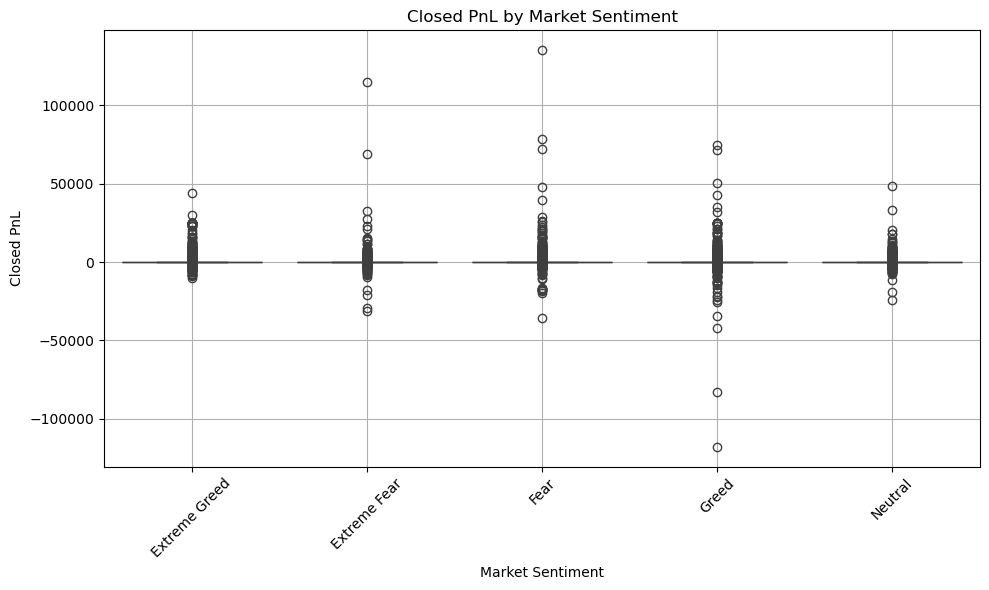

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='closed_pnl', data=merged_df)
plt.title('Closed PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Closed PnL')
plt.xlabel('Market Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


**After Filter Outliers**

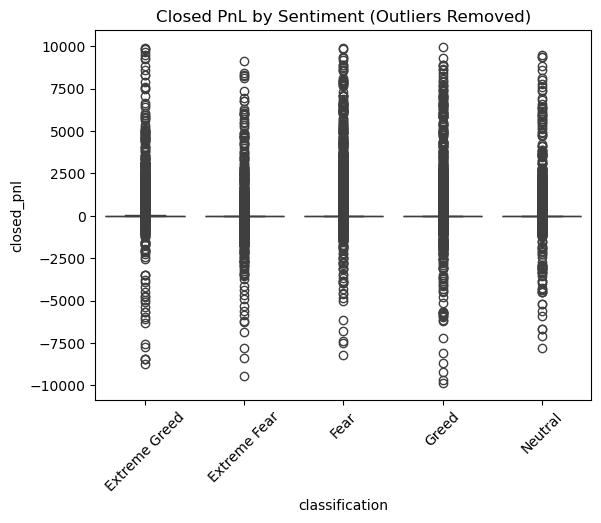

In [16]:
# Remove extreme PnL outliers for better visualization
filtered_df = merged_df[(merged_df['closed_pnl'] > -10000) & (merged_df['closed_pnl'] < 10000)]

sns.boxplot(x='classification', y='closed_pnl', data=filtered_df)
plt.title('Closed PnL by Sentiment (Outliers Removed)')
plt.xticks(rotation=45)
plt.show()


In [18]:
from scipy.stats import ttest_ind

fear = merged_df[merged_df['classification'] == 'Extreme Fear']['closed_pnl']
greed = merged_df[merged_df['classification'] == 'Extreme Greed']['closed_pnl']

t_stat, p_val = ttest_ind(fear, greed, equal_var=False)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")


T-statistic: -3.851
P-value: 0.0001


In [7]:
#Since p-value < 0.05, the difference is statistically significant → market sentiment does have a real impact on trader performance.